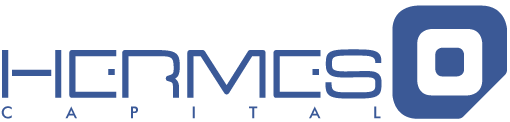
<p><center><font size="5" face="Times New Roman" color="#3b5996"><b>Financial Data Analyst Entry Task<br>Hermes Capital Quant Chapter<br>Fall 2023</b></font></center></p>
<center><font size="4" face="Times New Roman" color="#3b5996">Mohsen Kashefikia</font></center>

<p style="font-size:17px"><font face="gotham">
 First we Install python-binance for API interaction with <b>Binance</b>:
</font></p>

In [ ]:
!pip install python-binance

<p><font face="gotham"></font></p>

<p style="font-size:17px"><font face="gotham">
 Before starting tasks, we import the necessary libraries:
</font></p>

In [ ]:
import time
from copy import deepcopy
from datetime import datetime, timedelta

import pandas as pd
import numpy as np

from scipy.stats import kurtosis, skew, probplot, shapiro
from statsmodels.tsa.stattools import pacf, acf, adfuller
from statsmodels.graphics.gofplots import qqplot
import statsmodels.api as sm

from dateutil.parser import parse

import matplotlib.pyplot as plt
from plotly import subplots
from plotly.offline import iplot
import plotly.graph_objs as go

from binance.client import Client
from binance.exceptions import BinanceAPIException

import warnings 

warnings.filterwarnings('ignore')

<h1 style="background-color: #3b5996; padding: 10px;border-radius: 25px;"><center><font face="gotham" color="white">Task 1: Data Collection, Processing, and Resampling</font></center><h1>

<h2><font face="gotham" color="#3b5996">1.1 Data Collection: Fetching OHLCV Candlestick Data</font></h2>

<h3><font face="gotham" color="#3b5996">1. Modular Python Functions for API Interactions</font></h3>

<p style="font-size:17px"><font face="gotham">
 As the first step, we develop a class named <i>BinanceDataHandler</i> for fetching OHLCV data from <b>Binance</b> and saving it:
</font></p>

In [ ]:
def unix_to_datetime(unix_time):
    """
    Convert Unix timestamp to datetime format.

    Parameters:
    -----------
    unix_time : int
        Unix timestamp in milliseconds.

    Returns:
    -----------
    datetime.datetime
        Datetime representation of the Unix timestamp.
    """
    # Convert Unix timestamp from milliseconds to seconds
    return datetime.fromtimestamp(unix_time / 1000.0)


class BinanceDataHandler:
    """
    A class to handle fetching and saving Binance data.

    Attributes:
    ----------
    client : binance.client.Client
        Client object for interacting with the Binance API.
    """

    def __init__(self, api_key, api_secret):
        """
        Constructs all the necessary attributes for the BinanceDataHandler object.

        Parameters:
        ----------
        api_key : str
            API key for Binance.
        api_secret : str
            API secret for Binance.
        """
        # Initialize the Binance client with API key and secret
        self.client = Client(api_key, api_secret)
        self.exchange_name = 'binance'

    def fetch_historical_data(self, symbol, interval, start_str, end_str, delta_weeks=1):
        """
        Fetch OHLCV data from Binance and return it as a pandas DataFrame.

        Parameters:
        ----------
        symbol : str
            Exchange pair symbol (e.g., 'BTCUSDT').
        interval : str
            Time interval for the data (e.g., '1h', '1d').
        start_str : str
            Starting datetime in string format (e.g., '2021-01-01').
        end_str : str
            Ending datetime in string format (e.g., '2021-01-31').
        delta_weeks : int, optional
            Number of weeks for each data fetching interval, by default 1.

        Returns:
        -----------
        pandas.DataFrame
            DataFrame containing the fetched OHLCV data.
        """
        # Parse the start and end dates from strings to datetime objects
        start_date = parse(start_str)
        end_date = parse(end_str)
        # Define the time interval for data fetching
        delta = timedelta(weeks=delta_weeks)

        all_klines = []

        # Fetch data in chunks defined by delta until the end date is reached
        while start_date < end_date:
            start = start_date.strftime('%Y-%m-%d %H:%M:%S')
            end = (start_date + delta).strftime('%Y-%m-%d %H:%M:%S')
            while True:
                try:
                    # Fetch historical data from Binance
                    klines = self.client.get_historical_klines(
                        symbol, interval, start, end
                    )
                    print(
                        f"Historical data from {start} until {end} fetched successfully."
                    )
                    time.sleep(1)  # Pause to respect API rate limits
                    break
                except BinanceAPIException as e:
                    # Handle API exceptions and retry after a cooldown period
                    print("Error occurred!")
                    print(f"StatusCode = {e.status_code}, Message = {e.message}")
                    print("Cooling down for 10 seconds...")
                    time.sleep(10)
            # Append fetched data to the list
            all_klines.extend(klines)
            # Move to the next time interval
            start_date += delta

        # Convert raw data to a DataFrame
        ohlc_data = [
            [
                unix_to_datetime(kline[0]),
                float(kline[1]),
                float(kline[2]),
                float(kline[3]),
                float(kline[4]),
                float(kline[5]),
                'binance',
                symbol,
            ]
            for kline in all_klines
        ]
        df = pd.DataFrame(
            ohlc_data,
            columns=[
                'datetime',
                'open',
                'high',
                'low',
                'close',
                'volume',
                'exchange',
                'isin',
            ],
        )
        # Filter out data beyond the end date
        df = df[~(df['datetime'] > end_date.strftime('%Y-%m-%d %H:%M:%S'))]
        return df

    def save_historical_data(self, df, dataset_folder, file_name):
        """
        Save a pandas DataFrame to a CSV file.

        Parameters:
        ----------
        df : pandas.DataFrame
            DataFrame containing the OHLCV data.
        dataset_folder : str
            Directory path where the CSV file will be saved.
        file_name : str
            Name of the CSV file to save.
        """
        # Save DataFrame to a CSV file in the specified directory
        df.to_csv(f'{dataset_folder}/{file_name}.csv', index=False)

<p style="font-size:17px"><font face="gotham">
 As the next step, we fetch data from the requested start time until the requested end time, mentioned in the task description(Since we fetch public data from <b>Binance</b>, we don't need <i>api_key</i> and <i>api_secret</i>)
</font></p>



In [ ]:
# Initialize the BinanceDataHandler
bdh = BinanceDataHandler("", "")

# Fetch historical data for BTCUSDT with a 1-minute interval from the specified date range
btcusdt_binance_df = bdh.fetch_historical_data(
    'BTCUSDT', '1m', "2022-11-30 00:00:00", "2023-12-02 00:00:00", 1
)

In [ ]:
btcusdt_binance_df

<p style="font-size:17px"><font face="gotham">
 We save data fetched in previous script in csv format:
</font></p>

In [ ]:
# Save the fetched data to a CSV file
bdh.save_historical_data(btcusdt_binance_df, 'dataset', 'btcusdt_m1_binance')

<p style="font-size:17px"><font face="gotham">
    Now we read all csv files, save <b>OHLCV</b> data in <i>pandas DataFrame</i> format .In the next step we drop all duplicate records ,sort all <i>DataFrames</i> by <i>datetime</i> and set <i>datetime</i> column as index:
</font></p>

In [ ]:
# Set the folder where datasets are stored
dataset_folder = 'dataset'

# Define the date range for the data extraction
start_date = '2022-12-01 00:00:00'
end_date = '2023-12-01 00:00:00'

# List of exchange pairs to process
exchange_pairs = [
    'btcusdt-binance', 
    'usdttmn-wallex', 
    'usdttmn-tabdeal', 
    'usdttmn-nobitex', 
    'btctmn-wallex', 
    'btctmn-tabdeal', 
    'btctmn-nobitex'
]

# Dictionary to store processed data
data = dict()

def sort_pair_in_requested_dates(dataset_folder, file_name, start_date, end_date):
    """
    Read and sort data for a specific exchange pair within the requested date range.

    Parameters:
    -----------
    dataset_folder : str
        The folder where the dataset files are stored.
    file_name : str
        The name of the CSV file containing the data for the exchange pair.
    start_date : str
        The start date for the data extraction in 'YYYY-MM-DD HH:MM:SS' format.
    end_date : str
        The end date for the data extraction in 'YYYY-MM-DD HH:MM:SS' format.

    Returns:
    -----------
    pandas.DataFrame
        The DataFrame containing sorted data within the requested date range.
    """
    # Load the data from the CSV file
    df = pd.read_csv(f'{dataset_folder}/{file_name}')
    
    # Drop duplicate rows based on the 'datetime' column, keeping the first occurrence
    df = df.drop_duplicates(subset=['datetime'], keep='first')
    
    # Filter rows to include only those within the specified date range
    df = df[(start_date < df['datetime']) & (df['datetime'] < end_date)]
    
    # Sort the DataFrame by the 'datetime' column
    df = df.sort_values(by='datetime')
    
    # Convert 'datetime' column to datetime type and set it as the index
    df['datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace=True)
    
    return df

# Process each exchange pair and store the result in the 'data' dictionary
for exchange_pair in exchange_pairs:
    # Construct the file name by joining parts of the exchange pair with '_m1_'
    file_name = f'{"_m1_".join(exchange_pair.split("-"))}.csv'
    
    # Sort and filter data for the exchange pair within the specified date range
    data[exchange_pair] = sort_pair_in_requested_dates(dataset_folder, file_name, start_date, end_date)

In [ ]:
data['btcusdt-binance']

<h3><font face="gotham" color="#3b5996">2. Processing OHLCV Data into a Representative Price Series</font></h3>

<p style="font-size:17px"><font face="gotham">
    We create a function named <i>ohlcv_to_price_series</i> to change ohlcv format to a price series:
</font></p>

In [ ]:
def ohlcv_to_price_series(df, method):
    """
    Convert OHLCV DataFrame to a price series based on the specified method.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing OHLCV data with columns 'open', 'high', 'low', 'close', 'volume'.
    method : str
        Method to extract the price series (e.g. 'close' for closing prices).

    Returns:
    -----------
    pandas.DataFrame or None
        DataFrame with a single 'price' column if the method is recognized,
        otherwise None.
    """
    # Use a match-case statement to determine the method for extracting the price series
    match method:
        case "close":
            # Extract the 'close' column and rename it to 'price'
            return df[["close"]].rename(columns={'close': 'price'})
        case _:
            # Return None if the method is not recognized
            return None

<p style="font-size:17px"><font face="gotham">
   We choose <i>close</i> price as the price series value in convertion since:
    <ol>
        <li><b>Simplicity</b>: It is straightforward to use and easy to understand.</li> 
        <li><b>Commonly Used</b>: Many traders and analysts use the closing price for daily charts, making it a standard for comparison.</li>
        <li><b>Reflects Final Sentiment</b>: It reflects the final consensus of value for that period.</li>
    </ol>
</font></p>

<p style="font-size:17px"><font face="gotham">
   Now we imply convertion on all data we have:
</font></p>

In [ ]:
# Loop through each exchange pair in the data dictionary
for exchange_pair in data.keys():
    # Convert OHLCV data to a price series using the 'close' method
    data[exchange_pair] = ohlcv_to_price_series(data[exchange_pair], method='close')

In [ ]:
data['btctmn-nobitex']

<h3><font face="gotham" color="#3b5996">3. Extraction of Implied USDT-TMN Price Series:</font></h3>

<p style="font-size:17px"><font face="gotham">
   In this section First we create a function for finding number of gaps and maximum gap for each exchange pair:
</font></p>

In [ ]:
def find_minute_gap_info(df):
    """
    Find the maximum gap between consecutive timestamps in minutes and the number of such gaps in a DataFrame.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing data with a datetime index.

    Returns:
    -----------
    tuple
        A tuple containing the number of gaps and the maximum gap between consecutive timestamps in minutes.
    """
    # Calculate the time difference between consecutive timestamps in minutes
    time_diff = df.index.to_series().diff().dt.total_seconds() / 60
    
    # Select time differences greater than 1 minute (indicating a gap)
    gaps = time_diff.loc[lambda x: x > 1]
    
    # Return the number of gaps and the maximum gap
    return len(gaps), max(gaps)

<p style="font-size:17px"><font face="gotham">
   Now for each pair we print gaps information to decide which pairs are better to use:
</font></p>

In [ ]:
for exchange_pair in data.keys():
    # Find the number of gaps and the maximum gap for each exchange pair
    num_gaps, max_gap = find_minute_gap_info(data[exchange_pair])
    
    # Print the results for each exchange pair
    print(f"Number of gaps for {exchange_pair}: {num_gaps}, Maximum gap: {max_gap} minutes")

<p style="font-size:17px"><font face="gotham">
   As we see among all Iranian exchanges, <b>Nobitex</b> exchange data has the highest quality since having fewer missing records and <b>Tabdeal</b> exchange has the least quality since having the most missing records.<br> So for calculating the <i>USDT-TMN</i> pair we use <b>Nobitex</b> data for the <i>BTC-TMN</i> pair and <b>Binance</b> data for the <i>BTC-USDT</i> pair:
</font></p>

In [ ]:
# Merge the data from 'btctmn-nobitex' and 'btcusdt-binance' on their indices
merged_df = pd.merge(data['btctmn-nobitex'], data['btcusdt-binance'], left_index=True, right_index=True)

# Calculate the new 'price' column as the ratio of 'price_x' to 'price_y'
merged_df["price"] = merged_df["price_x"] / merged_df["price_y"]

# Create a new entry in the data dictionary with the calculated 'price'
# Drop the original 'price_x' and 'price_y' columns from the merged DataFrame
data['usdttmn-calculated'] = merged_df.drop(['price_x', 'price_y'], axis=1)

In [ ]:
data['usdttmn-calculated']

<p style="font-size:17px"><font face="gotham">
   At this section we choose these USDT-TMN price series for future parts:
<ol>
    <li><b>usdttmn-wallex</b>: <i>USDT-TMN</i> price series extracted from wallex</li>
  <li><b>usdttmn-nobitex</b>: <i>USDT-TMN</i> price series extracted from nobitex</li>
  <li><b>usdttmn-calculated</b>: <i>USDT-TMN</i> price series calculated of division <i>BTC-USDT</i> extracted from binance by <i>BTC-TMN</i> extracted from nobitex</li>
</ol>
</font></p>

In [ ]:
# List of chosen exchange pairs to keep in the data dictionary
chosen_data = ['usdttmn-wallex', 'usdttmn-nobitex', 'usdttmn-calculated']

# Filter the data dictionary to include only the chosen exchange pairs
data = {exchange_pair: data[exchange_pair] for exchange_pair in chosen_data}

<h2><font face="gotham" color="#3b5996">1.2 Resampling</font></h2>

<h3><font face="gotham" color="#3b5996">1. Selection of Time Scales:</font></h3>

<p style="font-size:17px"><font face="gotham">
   First, we create a deep copy of <i>data</i> to prevent unwanted changes on the previous part data and name it <i>resampled_data</i>:
</font></p>

In [ ]:
# Create a deep copy of the data dictionary to prevent modifications to the original data
resampled_data = deepcopy(data)

<p style="font-size:17px"><font face="gotham">
   Now we create a function for resampling price for each exchange pair:
</font></p>

In [ ]:
def resample_data(price_series, freq, method):
    """
    Resample the price series DataFrame to a specified frequency using the specified method.

    Parameters:
    -----------
    price_series : pandas.DataFrame
        DataFrame containing the price series with a datetime index.
    freq : str
        The new frequency to resample the data to (e.g., 'D' for daily, 'H' for hourly).
    method : str
        Method for resampling ('last' to take the last value in each resampled period).

    Returns:
    -----------
    pandas.DataFrame or None
        Resampled DataFrame if the method is recognized, otherwise None.
    """
    match method:
        case 'last':
            # Resample the price series to the specified frequency using the last value in each period
            return price_series.resample(freq).last()
        case _:
            # Return None if the method is not recognized
            return None

<p style="font-size:17px"><font face="gotham">
   We create new sampled data by resampling previous section data with given frequencies:
</font></p>

In [ ]:
frequencies = ['5min', '20min', '60min', '1440min']

# Loop through each exchange pair in the resampled_data dictionary
for exchange_pair in resampled_data.keys():
    # Dictionary to store resampled data for different frequencies
    frequencies_data = dict()
    
    # Loop through each frequency and resample the data
    for freq in frequencies:
        # Resample the data using the 'ffill' method (forward fill)
        frequencies_data[freq] = resample_data(resampled_data[exchange_pair], freq, 'last')
    
    # Update the resampled_data dictionary with the new frequencies data
    resampled_data[exchange_pair] = frequencies_data

<h3><font face="gotham" color="#3b5996">2. Methodological Approach:</font></h3>

<p style="font-size:17px"><font face="gotham">
   Since we are using <b>usdttmn-calculated</b> we can not calculate volume with extracted data in previous part, we can't use the <b>VWAP</b> approach for resampling. Furthermore, the <b>TWAP</b> approach is suitable for Long-Term Trends. As a result, <b>using the last record price</b> might be most suitable since:
    <ol>
        <li><b>Simplicity</b>: Extremely easy to understand and calculate.</li> 
        <li><b>Real-time Relevance</b>: Represents the most recent market conditions at the end of each interval.</li>
    </ol>
</font></p>

<h2><font face="gotham" color="#3b5996">1.3 Handling Market Anomalies</font></h2>

<h3><font face="gotham" color="#3b5996">1. Missing Data:</font></h3>

<p style="font-size:17px"><font face="gotham">
   First, we create a deep copy of <i>resampled_data</i> to prevent unwanted changes on the previous part data and name it <i>complete_data</i>:
</font></p>

In [ ]:
# Create a deep copy of the resampled_data dictionary to prevent modifications to the original data
complete_data = deepcopy(resampled_data)

<p style="font-size:17px"><font face="gotham">
   Now we create a function for filling missed price for each exchange pair:
</font></p>

In [ ]:
def fill_missed_data(price_series, method):
    """
    Fill missing data in the price series using the specified method.

    Parameters:
    -----------
    price_series : pandas.DataFrame or pandas.Series
        DataFrame or Series containing the price data with a datetime index.
    method : str
        Method to fill missing data ('linear interpolate' for linear interpolation, 'ffill' for forward fill).

    Returns:
    -----------
    pandas.DataFrame or pandas.Series or None
        The DataFrame or Series with missing data filled if the method is recognized, otherwise None.
    """
    match method:
        case 'linear interpolate':
            # Fill missing data using linear interpolation
            return price_series.interpolate(method='linear')
        case 'ffill':
            # Fill missing data using forward fill
            return price_series.ffill()
        case _:
            # Return None if the method is not recognized
            return None

<p style="font-size:17px"><font face="gotham">
   We fill missed data of all frequencies for each exchange pair:
</font></p>

In [ ]:
# Loop through each exchange pair in the data dictionary
for exchange_pair in complete_data.keys():
    # Loop through each frequency within the exchange pair data
    for freq in complete_data[exchange_pair].keys():
        # Fill missing data using the 'linear interpolate' method
        complete_data[exchange_pair][freq] = fill_missed_data(complete_data[exchange_pair][freq], 'linear interpolate')

<h3><font face="gotham" color="#3b5996">2. Outlier Detection and Correction:</font></h3>

<p style="font-size:17px"><font face="gotham">
    We choose zscore method for outlier detection. Fisrt, we define a <i>zscore</i> function used rolling window for outlier detection and replace outlier with rolling average:
</font></p>

In [ ]:
def zscore(df, window, thresh=3, return_all=False):
    """
    Calculate the z-score for the given DataFrame, and optionally return the mean, standard deviation, 
    and a mask of values within the specified threshold.

    Parameters:
    -----------
    df : pandas.DataFrame or pandas.Series
        The input data to calculate the z-score for.
    window : int
        The rolling window size to calculate the mean and standard deviation.
    thresh : float, optional (default=3)
        The z-score threshold to identify outliers. Values with z-score beyond this threshold will be considered outliers.
    return_all : bool, optional (default=False)
        If True, return the z-score, mean, standard deviation, and mask. Otherwise, return the DataFrame with outliers replaced by the mean.

    Returns:
    -----------
    pandas.DataFrame or pandas.Series, tuple
        The DataFrame with outliers replaced by the mean if return_all is False.
        If return_all is True, return a tuple containing the z-score, mean, standard deviation, and mask.
    """
    # Calculate rolling mean and standard deviation
    roll = df.rolling(window=window, min_periods=1, center=True)
    avg = roll.mean()
    std = roll.std(ddof=0)
    
    # Calculate z-score
    z = df.sub(avg).div(std)
    
    # Create a mask for values within the threshold
    m = z.between(-thresh, thresh)
    
    if return_all:
        return z, avg, std, m
    
    # Replace outliers with the mean
    return df.where(m, avg)

<p style="font-size:17px"><font face="gotham">
    Now we plot all price sereies with their rolling average. Furthermore, we specify all outlier points with their replacemen:
</font></p>

In [ ]:
def create_figure_of_missing_data_and_replacement(exchange_pair, freq, price_series, zscore_info):
    """
    Create traces for a Plotly figure to visualize missing data and its replacement.

    Parameters:
    -----------
    exchange_pair : str
        The exchange pair being processed.
    freq : str
        The frequency of the data.
    price_series : pandas.DataFrame
        DataFrame containing the price series data.
    zscore_info : tuple
        A tuple containing z-score, mean, standard deviation, and mask of valid values.

    Returns:
    -----------
    list
        A list of Plotly Scatter traces.
    """
    z, avg, std, m = zscore_info
    x1 = price_series.index.values
    x2 = avg[~m].index.values

    # Trace for the original data
    trace1 = go.Scatter(
        x=x1,
        y=price_series.price.values,
        marker=dict(color="blue"),
        name='data'
    )

    # Trace for the rolling mean
    trace2 = go.Scatter(
        x=x1,
        y=avg.values,
        marker=dict(color="red"),
        name='mean'
    )

    # Trace for the detected outliers
    trace3 = go.Scatter(
        x=x2,
        y=price_series.loc[~m, 'price'].values,
        marker=dict(color="green", size=5),
        mode="markers",
        name='outliers'
    )

    # Trace for the replacement values
    trace4 = go.Scatter(
        x=x2,
        y=avg[~m].values,
        marker=dict(color="gold", size=5),
        mode="markers",
        name='replacement'
    )

    return [trace1, trace2, trace3, trace4]

def plot_figures_for_each_exchange_pair(data, exchange_pair, windows):
    """
    Plot figures for each exchange pair and frequency, showing missing data handling.

    Parameters:
    -----------
    data : dict
        Dictionary containing the price data for different exchange pairs and frequencies.
    exchange_pair : str
        The exchange pair being processed.
    windows : dict
        Dictionary containing the window sizes for different frequencies.

    Returns:
    -----------
    None
    """
    figures = []
    subplot_titles = []

    for freq in data[exchange_pair].keys():
        price_series = data[exchange_pair][freq]
        zscore_info = zscore(price_series.price, window=windows[freq], return_all=True)

        # Add title for each subplot
        subplot_titles.append(f"time-frame-interval = {freq}")

        # Create figure for each frequency
        figures.append(create_figure_of_missing_data_and_replacement(exchange_pair, freq, price_series, zscore_info))

    # Create subplots for each frequency
    fig = subplots.make_subplots(rows=len(figures), cols=1, subplot_titles=tuple(subplot_titles))

    # Add each trace to the subplot
    for i, figure in enumerate(figures):
        for trace in figure:
            fig.add_trace(trace, row=i+1, col=1)
            fig.update_xaxes(title_text="datetime", row=i+1, col=1)
            fig.update_yaxes(title_text="price", row=i+1, col=1)

    fig.update_layout(title_text=f'Missing data handling for {exchange_pair}', height=1000)
    iplot(fig)


<p style="font-size:17px"><font face="gotham">
    We set three days as window for rolling average.
</font></p>

In [ ]:
# Define the window sizes for different frequencies
windows = {'5min': 864, '20min': 216, '60min': 72, '1440min': 3}

In [ ]:
# Loop through each exchange pair in the complete data
for exchange_pair in complete_data.keys(): 
    plot_figures_for_each_exchange_pair(complete_data, exchange_pair, windows)

<h3><font face="gotham" color="#3b5996">3. Data Integrity Assurance:</font></h3>

<p style="font-size:17px"><font face="gotham">
    First, we define a function named <i>print_data_metrics</i> that prints all frequency data metrics for each exchange pair:
</font></p>

In [ ]:
def print_data_metrics(data_exchange_pair):
    """
    Generate and print descriptive statistics for each frequency of a given exchange pair.

    Parameters:
    -----------
    data_exchange_pair : dict
        Dictionary containing the price data for different frequencies of an exchange pair.

    Returns:
    -----------
    pandas.DataFrame
        A DataFrame containing the concatenated descriptive statistics for each frequency.
    """
    data_info = []
    for freq in data_exchange_pair.keys():
        # Generate descriptive statistics for the current frequency
        data_info.append(data_exchange_pair[freq].describe())
    
    # Concatenate descriptive statistics for all frequencies into a single DataFrame
    return pd.concat(data_info, axis=1, keys=list(data_exchange_pair.keys()))

In [ ]:
print_data_metrics(complete_data['usdttmn-wallex'])

In [ ]:
print_data_metrics(complete_data['usdttmn-nobitex'])

In [ ]:
print_data_metrics(complete_data['usdttmn-calculated'])

<p style="font-size:17px"><font face="gotham">
    Now we print all frequency metrics for each exchange pair again after implying zscore method for outlier detection and replacement:
</font></p>

In [ ]:
# Normalize price data using z-score for each exchange pair and frequency
for exchange_pair in complete_data.keys():
    for freq in complete_data[exchange_pair].keys():
        # Update the price column with z-score normalized values
        complete_data[exchange_pair][freq]['price'] = zscore(complete_data[exchange_pair][freq]['price'], window=windows[freq])

In [ ]:
print_data_metrics(complete_data['usdttmn-wallex'])

In [ ]:
print_data_metrics(complete_data['usdttmn-nobitex'])

In [ ]:
print_data_metrics(complete_data['usdttmn-calculated'])

<p style="font-size:17px"><font face="gotham">
    As we see after applying the zscore method, our data distribution does not change significantly. If we look at important metrics of data distribution like <b>mean</b>, <b>std</b>, <b>min</b>, <b>max</b>, and <b>quantiles</b> we see no big difference after outlier replacement. Furthermore, we can see our data cleaning process preserves data consistency successfully since we don't drop outliers and replace them with suitable records.
</font></p>

<h1 style="background-color: #3b5996; padding: 10px;border-radius: 25px;"><center><font face="gotham" color="white">Task 2: Exploratory Data Analysis (EDA)</font></center><h1>

<p style="font-size:17px"><font face="gotham">
   First, we create a deep copy of <i>complete_data</i> to prevent unwanted changes on the previous part data and name it <i>clean_data</i>:
</font></p>

In [ ]:
# Create a deep copy of the data dictionary to prevent modifications to the original data
clean_data = deepcopy(complete_data)

<h2><font face="gotham" color="#3b5996">2.1 Log Returns, Volatility, and Normality Assessment</font></h2>

<h3><font face="gotham" color="#3b5996">1. Log Returns Computation:</font></h3>

<p style="font-size:17px"><font face="gotham">
   We create a function named <i>calculate_log_return</i> to calculate log return with prices:
</font></p>

In [ ]:
def calculate_log_return(df, col='price', periods=1):
    """
    Calculate the logarithmic return of a specified column in a DataFrame.

    Parameters:
    -----------
    df : pandas.DataFrame
        The input data frame containing the price data.
    col : str, optional (default='price')
        The column name for which to calculate the logarithmic return.
    periods : int, optional (default=1)
        The number of periods to shift for calculating the return.

    Returns:
    -----------
    pandas.DataFrame
        The input DataFrame with an additional 'log_return' column containing the logarithmic returns.
    """
    # Calculate the natural logarithm of the specified column
    log_df = np.log(df[col])

    # Calculate the difference between the log values and their shifted version
    df["log_return"] = log_df - log_df.shift(periods=periods)
    
    return df


In [ ]:
# Apply the log return calculation to each exchange pair and frequency in the clean_data dictionary
for exchange_pair in clean_data.keys():
    for freq in clean_data[exchange_pair].keys():
        clean_data[exchange_pair][freq] = calculate_log_return(clean_data[exchange_pair][freq])

<h3><font face="gotham" color="#3b5996">2. Volatility Estimation and Clustering Analysis with EWMA:</font></h3>

<p style="font-size:17px"><font face="gotham">
   We define a function named <i>calculate_ewma_volatility</i> to calculate Exponentially
Weighted Moving Average model to gauge market volatility:
</font></p>

In [ ]:
def calculate_ewma_volatility(df, span=30):
    """
    Calculate the Exponentially Weighted Moving Average (EWMA) volatility for a DataFrame.

    Parameters:
    -----------
    df : pandas.DataFrame
        The input data frame containing a 'log_return' column.
    span : int, optional (default=30)
        The span for the EWMA, which determines the decay factor (lambda).

    Returns:
    -----------
    pandas.DataFrame
        The input DataFrame with an additional 'EWMA_volatility' column containing the calculated volatility.
    """
    # Calculate the squared log returns
    squared_log_returns = df['log_return'] ** 2

    # Calculate the EWMA of the squared log returns
    # 'span' corresponds to the (2 / (1 + lambda)) in the decay formula, where lambda is the decay factor
    ewma_variance = squared_log_returns.ewm(span=span).mean()

    # The standard deviation (volatility) is the square root of the variance
    ewma_volatility = np.sqrt(ewma_variance)

    # Create EWMA volatility column
    df["EWMA_volatility"] = ewma_volatility

    return df

In [ ]:
for exchange_pair in clean_data.keys():
    for freq in clean_data[exchange_pair].keys():
        # Calculate EWMA volatility for each frequency data
        clean_data[exchange_pair][freq] = calculate_ewma_volatility(clean_data[exchange_pair][freq])

In [ ]:
def create_log_return_and_ewma_plot(df):
    """
    Create plot traces for EWMA volatility and log returns.

    Parameters:
    df (pd.DataFrame): DataFrame containing 'EWMA_volatility' and 'log_return' columns.

    Returns:
    list: List of plotly graph objects for EWMA volatility and log return.
    list: List of titles for the subplots.
    """
    # Create a scatter plot for EWMA volatility
    trace1 = go.Scatter(
        x=df.index.values,  # x-axis values: datetime index
        y=df['EWMA_volatility'].values,  # y-axis values: EWMA volatility
        marker=dict(color="blue"),  # marker color
        name='ewma_volatility'  # legend name
    )
    
    # Create a scatter plot for log return
    trace2 = go.Scatter(
        x=df.index.values,  # x-axis values: datetime index
        y=df['log_return'].values,  # y-axis values: log return
        marker=dict(color="red"),  # marker color
        name='log_return'  # legend name
    )

    # Return the list of traces and their titles
    return [trace1, trace2], ['ewma_volatility', 'log_return']

def plot_log_return_and_ewma(df_exchange_pair):
    """
    Plot EWMA volatility and log returns for different frequency data.

    Parameters:
    df_exchange_pair (dict): Dictionary containing dataframes for different frequencies.

    Returns:
    None
    """
    # Iterate over each frequency in the dictionary
    for freq in df_exchange_pair.keys():
        # Get the price series data for the current frequency
        price_series = df_exchange_pair[freq]
        
        # Create plot traces and titles
        traces, titles = create_log_return_and_ewma_plot(price_series)

        # Create subplots, one for each trace
        fig = subplots.make_subplots(rows=len(traces), cols=1, subplot_titles=titles)

        # Append each trace to the respective subplot
        for i, trace in enumerate(traces):
            fig.append_trace(trace, row=i + 1, col=1)

        # Update layout of the figure
        fig.update_layout(height=600, title_text=f"time-frame-interval = {freq}")
        
        # Display the plot
        iplot(fig)

In [ ]:
plot_log_return_and_ewma(clean_data["usdttmn-nobitex"])

In [ ]:
plot_log_return_and_ewma(clean_data["usdttmn-wallex"])

In [ ]:
plot_log_return_and_ewma(clean_data["usdttmn-calculated"])

<p style="font-size:17px"><font face="gotham">
    <b>Volatility clustering</b> is a phenomenon in financial time series where periods of high volatility tend to be followed by high volatility and periods of low volatility tend to be followed by low volatility. This characteristic indicates that volatility is not constant over time and can be autocorrelated.
</font></p>
<p style="font-size:17px"><font face="gotham">
    Now we cluster our volatility in 3 clusters:
    <ol>
        <li><b>High Volatility Clusters</b> : These periods often correspond to market stress or major economic announcements. For traders and risk managers, these clusters signal a need for increased caution, potential deleveraging, or the implementation of hedging strategies to protect against adverse movements.</li>
        <li><b>Low Volatility Clusters</b> : Typically indicate periods of market calm but can also precede significant market moves (as per the "calm before the storm" scenario). Strategic decisions here might involve increasing exposure to capture potential moves or taking advantage of low option premiums when constructing hedging strategies.</li>
        <li><b>Transition Phases Volatility Clusters</b> : The periods transitioning between high and low volatility are particularly critical as they might indicate a change in market regime. Detecting these changes early can be pivotal for adjusting portfolios in anticipation of increased risk or opportunity.</li>
    </ol>
</font></p>
<p style="font-size:17px"><font face="gotham">
    At last we mention implications for risk management and trading strategies:
    <ol>
        <li><b>Dynamic Position Sizing</b> : Adjusting trade sizes based on the prevailing volatility regime. Larger positions might be justified during low volatility regimes, whereas reducing exposure during high volatility can mitigate risk.</li>
        <li><b>Stop-Loss Adjustments</b> : Volatility clustering can inform the placement of stop-loss orders. Wider stops might be necessary during high volatility regimes to avoid being stopped out prematurely.</li>
        <li><b>Portfolio Diversification</b> : Understanding volatility patterns can guide the diversification strategies. During high volatility regimes, adding non-correlated assets or assets that thrive in volatile markets (like gold or certain types of options) can improve portfolio resilience.</li>
        <li><b>Strategic Entry/Exit Timing</b> : Identifying clusters can help in timing market entry and exit, optimizing trade execution around expected volatility changes.</li>
        <li><b>Stress Testing</b> : Using historical volatility clusters to model potential future scenarios and stress test portfolios against extreme events.</li>
    </ol>
</font></p>

<h3><font face="gotham" color="#3b5996">3. Statistical Summaries:</font></h3>

In [ ]:
def find_statistical_metrics(series, name):
    """
    Calculate statistical metrics for a given series.

    Parameters:
    series (pd.Series): The data series for which to calculate metrics.
    name (str): The name to assign to the column in the resulting DataFrame.

    Returns:
    pd.DataFrame: DataFrame containing mean, standard deviation, skewness, and kurtosis of the series.
    """
    # Calculate statistical metrics
    statistical_metrics = {
        "mean": series.mean(),
        "std": series.std(),
        "skewness": skew(series),
        "kurtosis": kurtosis(series)
    }
    
    # Convert the dictionary of metrics to a DataFrame
    return pd.DataFrame.from_dict(statistical_metrics, orient='index', columns=[name])

def find_statistical_metrics_ewma_and_log_return(df_exchange_pair):
    """
    Calculate statistical metrics for EWMA volatility and log returns for different frequencies.

    Parameters:
    df_exchange_pair (dict): Dictionary containing dataframes for different frequencies.

    Returns:
    pd.DataFrame: DataFrame containing the statistical metrics for each frequency.
    """
    all_infos = []  # List to store metrics for all frequencies
    
    # Iterate over each frequency in the dictionary
    for freq in df_exchange_pair.keys():
        # Get the price series data for the current frequency
        price_series = df_exchange_pair[freq]
        
        # Calculate statistical metrics for log return and EWMA volatility
        log_return_info = find_statistical_metrics(price_series['log_return'].dropna(), "log_return")
        ewma_volatility_info = find_statistical_metrics(price_series['EWMA_volatility'].dropna(), "EWMA_volatility")
        
        # Append the combined metrics to the list
        all_infos.append(pd.concat([log_return_info, ewma_volatility_info], axis=1))
        
    # Concatenate all metrics DataFrames into a single DataFrame
    return pd.concat(all_infos, axis=1, keys=list(df_exchange_pair.keys()))


In [ ]:
find_statistical_metrics_ewma_and_log_return(clean_data["usdttmn-wallex"])

In [ ]:
find_statistical_metrics_ewma_and_log_return(clean_data["usdttmn-nobitex"])

In [ ]:
find_statistical_metrics_ewma_and_log_return(clean_data["usdttmn-calculated"])

<h3><font face="gotham" color="#3b5996">4. Graphical Normality Tests:</font></h3>

In [ ]:
def qqplot_all_frequencies(df_exchange_pair, col):
    """
    Generate QQ plots for a specified column across different frequencies.

    Parameters:
    df_exchange_pair (dict): Dictionary containing dataframes for different frequencies.
    col (str): The column for which to generate the QQ plots.

    Returns:
    None
    """
    num_frequencies = len(df_exchange_pair.keys())
    num_cols = 2  # Number of columns in the subplot grid
    num_rows = (num_frequencies + 1) // num_cols  # Number of rows in the subplot grid
    
    # Create a figure with subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))
    ax = axes.flatten()  # Flatten the axes array for easy iteration
    fig.suptitle('Quantile-Quantile Plot')  # Set the super title for the figure
    
    # Iterate over each frequency and create a QQ plot
    for i, freq in enumerate(df_exchange_pair.keys()):
        qqplot(df_exchange_pair[freq][col].dropna(), fit=True, line='q', ax=ax[i])
        ax[i].set_title(f"time-frame-interval = {freq}")  # Set title for each subplot
        ax[i].set_xticks(np.arange(-5, 6, 1))  # Set x-axis ticks
        ax[i].grid(True)  # Enable grid for each subplot
    
    # Hide any unused subplots
    for j in range(i + 1, len(ax)):
        fig.delaxes(ax[j])
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the title
    plt.show()


In [ ]:
qqplot_all_frequencies(clean_data["usdttmn-wallex"],'log_return')

In [ ]:
qqplot_all_frequencies(clean_data["usdttmn-nobitex"],'log_return')

In [ ]:
qqplot_all_frequencies(clean_data["usdttmn-calculated"],'log_return')

<p style="font-size:17px"><font face="gotham">
   After plotting <b>QQ plot</b> for log returns of existed resampled data as we see, <i>5-minute</i> data has the most similarity to normality distribution and <i>1440-minute</i> data has the least similarity.
</font></p>
<p style="font-size:17px"><font face="gotham">
    We should mention that general form of <b>QQ plot</b> for log returns is <b>heavy tailed</b> format meaning that <u>compared to the normal distribution there is much more data located at the extremes of the distribution and less data in the center of the distribution</u> like this:
    <img src="./images/fat_tail.png" alt="HTML5 Icon" style="width:300px;height:300px;">
</font></p>

In [ ]:
# def qqplot_data(series):
    
#     qqplot_data = probplot(series)
#     x = np.array([qqplot_data[0][0][0], qqplot_data[0][0][-1]])
    
# #     fig = go.Figure()

#     trace_1 = go.Scatter(
#         x=qqplot_data[0][0],
#         y=qqplot_data[0][1],
#         mode='markers',
#         marker=dict(color='#1f77b4')        
#     )

#     trace_2 = go.Scatter(
#         x=x,
#         y=qqplot_data[1][1]+x*qqplot_data[1][0],
#         mode='lines',
#         marker=dict(color='#ff4040')  
#     )
    
#     return [trace_1, trace_2]

# def qqplot_all_frequencies(df_exchange_pair, col):
    
#     figures = []
#     subplot_titles = []
    
#     for freq in df_exchange_pair.keys():
#         series = df_exchange_pair[freq][col].dropna()
#         subplot_titles.append(f"time-frame-interval = {freq}")
#         figures.append(qqplot_data(series))
        
#     fig = subplots.make_subplots(rows=len(figures), cols=1, subplot_titles=tuple(subplot_titles))

#     for i, figure in enumerate(figures):
#             for trace in figure:
#                 fig.add_trace(trace, row=i+1, col=1)
#                 fig.update_xaxes(title_text="Theoritical Quantities", row=i+1, col=1)
#                 fig.update_yaxes(title_text="Sample Quantities", row=i+1, col=1)

#     fig.update_layout(title_text='Quantile-Quantile Plot')
#     iplot(fig)

In [ ]:
# qqplot_all_frequencies(clean_data["usdttmn-wallex"],'log_return')
# qqplot_all_frequencies(clean_data["usdttmn-nobitex"],'log_return')
# qqplot_all_frequencies(clean_data["usdttmn-calculated"],'log_return')

<h3><font face="gotham" color="#3b5996">5. Quantitative Normality Tests:</font></h3>

In [ ]:


def print_shapiro_test(df_exchange_pair, col):
    """
    Perform the Shapiro-Wilk test for normality on a specified column across different frequencies.

    Parameters:
    df_exchange_pair (dict): Dictionary containing dataframes for different frequencies.
    col (str): The column for which to perform the Shapiro-Wilk test.

    Returns:
    pd.DataFrame: DataFrame containing the Shapiro-Wilk test statistic and p-value for each frequency.
    """
    all_infos = []  # List to store test results for all frequencies
    
    # Iterate over each frequency in the dictionary
    for freq in df_exchange_pair.keys():
        # Perform the Shapiro-Wilk test on the specified column
        statistic, pvalue = shapiro(df_exchange_pair[freq][col].dropna())
        
        # Create a DataFrame from the test results
        test_results = pd.DataFrame.from_dict({
            "statistic": statistic,
            "pvalue": pvalue
        }, orient='index', columns=[f"Shapiro-Wilk Test"])
        
        # Append the test results to the list
        all_infos.append(test_results)
    
    # Concatenate all test results into a single DataFrame
    return pd.concat(all_infos, axis=1, keys=list(df_exchange_pair.keys()))


In [ ]:
print_shapiro_test(clean_data["usdttmn-wallex"],'log_return')

In [ ]:
print_shapiro_test(clean_data["usdttmn-nobitex"],'log_return')

In [ ]:
print_shapiro_test(clean_data["usdttmn-calculated"],'log_return')

<p style="font-size:17px"><font face="gotham">
    we should consider that for NumOfSamples > 5000 the W test statistic is accurate, but the p-value may not be.
</font></p>

<h3><font face="gotham" color="#3b5996">6. Importance of Normality:</font></h3>

<p style="font-size:17px"><font face="gotham">
    Now we name the important factors explained significance of a normal distribution in Financial Modeling and Risk Assessment:
    <ol>
        <li><b>Predictable Properties</b> : The normal distribution is essential in financial modeling because it has well-known properties that facilitate analytic solutions and statistical inference. It is symmetric around its mean, describing how the values of a variable are distributed. This makes it easier to calculate probabilities and quantiles.</li>
        <li><b>Risk Measures</b> : In risk management, measures such as Value at Risk (VaR) and Expected Shortfall (ES) often rely on normally distributed return assumptions for simplicity and calculability. These measures are pivotal in determining the potential loss in value of assets or portfolios.</li>
        <li><b>Central Limit Theorem</b> : The significance of the normal distribution is further underscored by the Central Limit Theorem (CLT), which states that the sum (or average) of a large number of independent, identically distributed variables tends toward a normal distribution, regardless of the original distribution of the variables. This property is widely used to justify the use of normal distributions in various models.</li>
    </ol>
</font></p>

<p style="font-size:17px"><font face="gotham">
    Finally, we discuss about Challenges of Non-Normality:
    <ol>
        <li><b>Fat Tails and Extreme Events</b> : Real-world financial data often exhibit fat tails, meaning they have a higher probability of extreme values than predicted by a normal distribution. This non-normality can significantly alter risk assessments by underestimating the likelihood and impact of extreme market movements.</li>
        <li><b>Skewness</b> : Financial returns can be skewed rather than symmetrically distributed, causing models that assume normal distribution to misestimate risk. Positive or negative skewness implies that returns are more likely to be greater or less than what a normal distribution suggests, impacting decision-making and risk strategies.</li>
        <li><b>Volatility Clustering</b> : Financial markets often exhibit periods of high and low volatility clustering. Models based on normal distribution assumptions might fail to capture this dynamic characteristic, possibly leading to underestimating risk in volatile periods and overestimating it during stable periods. This inconsistency can result in ineffective risk management and strategy development.</li>
        <li><b>Incorrect Parameter Estimation</b> : Non-normality in data affects parameter estimation procedures, leading to biased or inconsistent estimates of mean, variance, and correlations. This could result in inaccurate risk evaluations and affect the reliability of stress tests and scenario analyses.</li>
    </ol>
</font></p>

<h2><font face="gotham" color="#3b5996">2.2 Autocorrelation and Stationarity Analysis</font></h2>

<h3><font face="gotham" color="#3b5996">1. ACF and PACF Plots:</font></h3>

In [ ]:
def create_corr_plot(series, mode, alpha):
    """
    Create correlation plot traces for ACF or PACF.

    Parameters:
    series (pd.Series): The time series data.
    mode (str): Mode of correlation ('acf' or 'pacf').
    alpha (float): Significance level for confidence intervals.

    Returns:
    list: List of plotly graph objects for the correlation plot.
    """
    # Calculate correlation array and confidence intervals based on mode
    match mode:
        case "acf":
            corr_array = acf(series.dropna(), alpha=alpha)
        case "pacf":
            corr_array = pacf(series.dropna(), alpha=alpha)
    
    # Calculate the lower and upper confidence intervals
    lower_y = corr_array[1][:, 0] - corr_array[0]
    upper_y = corr_array[1][:, 1] - corr_array[0]
    
    # Create traces for the correlation plot
    traces = [go.Scatter(x=(x, x), y=(0, corr_array[0][x]), mode='lines', line_color='#3f3f3f') for x in range(len(corr_array[0]))]
    traces.append(go.Scatter(x=np.arange(len(corr_array[0])), y=corr_array[0], mode='markers', marker_color='#1f77b4', marker_size=12))
    traces.append(go.Scatter(x=np.arange(len(corr_array[0])), y=upper_y, mode='lines', line_color='rgba(255, 255, 255, 0)'))
    traces.append(go.Scatter(x=np.arange(len(corr_array[0])), y=lower_y, mode='lines', fillcolor='rgba(32, 146, 230, 0.3)',
                             fill='tonexty', line_color='rgba(255, 255, 255, 0)'))
    return traces

def create_corr_plot_all_frequencies(df_exchange_pair, col, mode, alpha):
    """
    Create correlation plots for a specified column across different frequencies.

    Parameters:
    df_exchange_pair (dict): Dictionary containing dataframes for different frequencies.
    col (str): The column for which to generate the correlation plots.
    mode (str): Mode of correlation ('acf' or 'pacf').
    alpha (float): Significance level for confidence intervals.

    Returns:
    None
    """
    # Set plot title based on mode
    title = "Autocorrelation (ACF)" if mode == "acf" else "Partial Autocorrelation (PACF)"
    
    # Generate subplot titles
    titles = [f"time-frame-interval = {freq}" for freq in df_exchange_pair.keys()]
    
    # Create subplots
    fig = subplots.make_subplots(rows=len(df_exchange_pair.keys()), cols=1, subplot_titles=tuple(titles))
    
    # Create and add traces for each frequency
    for i, freq in enumerate(df_exchange_pair.keys()):
        series = df_exchange_pair[freq][col]
        corr_traces = create_corr_plot(series, mode, alpha)
        
        for trace in corr_traces:
            fig.add_trace(trace, row=i+1, col=1)
            fig.update_xaxes(title_text="lag", row=i+1, col=1)
            fig.update_yaxes(title_text=mode, row=i+1, col=1)
            fig.update_traces(showlegend=False)
            fig.update_xaxes(range=[-1, 42])
            fig.update_yaxes(zerolinecolor='#000000')
    
    # Update layout and display plot
    fig.update_layout(title_text=title, height=1000)
    iplot(fig)

def create_acf_and_pacf_plot(df_exchange_pair, col, alpha=0.05):
    """
    Create both ACF and PACF plots for a specified column across different frequencies.

    Parameters:
    df_exchange_pair (dict): Dictionary containing dataframes for different frequencies.
    col (str): The column for which to generate the correlation plots.
    alpha (float): Significance level for confidence intervals.

    Returns:
    None
    """
    create_corr_plot_all_frequencies(df_exchange_pair, col, 'acf', alpha)
    create_corr_plot_all_frequencies(df_exchange_pair, col, 'pacf', alpha)

<p style="font-size:17px"><font face="gotham">
   Fisrt, we set significance level for confidence intervals or $\alpha$ to 0.05.
</font></p>
<p style="font-size:17px"><font face="gotham">
    As the next step, we plot <b>ACF</b> and <b>PACF</b> of log retrun column for each frequency separately:
</font></p>

In [ ]:
create_acf_and_pacf_plot(clean_data["usdttmn-wallex"],'log_return', alpha=0.05)

In [ ]:
create_acf_and_pacf_plot(clean_data["usdttmn-nobitex"],'log_return', alpha=0.05)

In [ ]:
create_acf_and_pacf_plot(clean_data["usdttmn-calculated"],'log_return', alpha=0.05)

<p style="font-size:17px"><font face="gotham">
    According to <b>ACF</b> and <b>PACF</b> above plots, we can see that for <u>1440-min resampled data</u> there is <u>no correlation between original series and lagged series</u>, but in <u>other frequencies resampled data</u>, we obviosly see <u>a significant corrolation with fisrt lag</u>.
</font></p>

In [ ]:
create_acf_and_pacf_plot(clean_data["usdttmn-wallex"],'EWMA_volatility', alpha=0.05)

In [ ]:
create_acf_and_pacf_plot(clean_data["usdttmn-nobitex"],'EWMA_volatility', alpha=0.05)

In [ ]:
create_acf_and_pacf_plot(clean_data["usdttmn-calculated"],'EWMA_volatility', alpha=0.05)

<p style="font-size:17px"><font face="gotham">
    According to <b>ACF</b> plot of <i>EWMA_volatility</i> column as seen above, we can see that for all resampled data <u>there is a significant correlation with lagged data and the scatter decays slowly indicating high persistence in volatility (volatility clustering)</u>. And by looking at <b>PACF</b> plot, we can identify at which lag the autocorrelation effect diminishes. <u>For most of them first lag and second lag are correlated significantly except 1440min frequency resampled data that include only first lag</u>.
</font></p>

In [ ]:
create_acf_and_pacf_plot(clean_data["usdttmn-wallex"],'price', alpha=0.05)

In [ ]:
create_acf_and_pacf_plot(clean_data["usdttmn-nobitex"],'price', alpha=0.05)

In [ ]:
create_acf_and_pacf_plot(clean_data["usdttmn-calculated"],'price', alpha=0.05)

<p style="font-size:17px"><font face="gotham">
    <b>ACF</b> and <b>PACF</b> plot for <i>price series</i> are pretty similar <u>except speed of decaying acf plot so there's more lagged data which are correlated</u>.
</font></p>

<h3><font face="gotham" color="#3b5996">2. Stationarity Testing:</font></h3>

In [ ]:
def adf_test(series):
    """
    Perform the Augmented Dickey-Fuller (ADF) test for stationarity on a given series.

    Parameters:
    series (pd.Series): The time series data.

    Returns:
    pd.DataFrame: DataFrame containing the ADF test statistic, p-value, number of lags used, 
                  number of observations used, and critical values.
    """
    indices = ["Test Statistic", "p-value", "# of Lags Used", "# of Observations Used"]
    
    # Perform ADF test
    adf_results_all = adfuller(series.dropna())
    results = pd.Series(adf_results_all[0:4], index=indices)
    
    # Add critical values to the results
    for key, value in adf_results_all[4].items():
        results[f'Critical Value ({key})'] = value
    
    # Convert the results to a DataFrame
    results = pd.DataFrame(results, columns=['statistics'])
    return results

def adf_test_for_all_frequencies(df_exchange_pair, col):
    """
    Perform the Augmented Dickey-Fuller (ADF) test for stationarity on a specified column 
    across different frequencies.

    Parameters:
    df_exchange_pair (dict): Dictionary containing dataframes for different frequencies.
    col (str): The column for which to perform the ADF test.

    Returns:
    pd.DataFrame: DataFrame containing the ADF test results for each frequency.
    """
    all_infos = []  # List to store test results for all frequencies
    
    # Iterate over each frequency in the dictionary
    for freq in df_exchange_pair.keys():
        series = df_exchange_pair[freq][col]
        adf_result = adf_test(series)
        all_infos.append(adf_result)
    
    # Concatenate all test results into a single DataFrame
    return pd.concat(all_infos, axis=1, keys=list(df_exchange_pair.keys()))


In [ ]:
adf_test_for_all_frequencies(clean_data["usdttmn-wallex"], 'log_return')

In [ ]:
adf_test_for_all_frequencies(clean_data["usdttmn-nobitex"], 'log_return')

In [ ]:
adf_test_for_all_frequencies(clean_data["usdttmn-calculated"], 'log_return')

In [ ]:
adf_test_for_all_frequencies(clean_data["usdttmn-wallex"], 'EWMA_volatility')

In [ ]:
adf_test_for_all_frequencies(clean_data["usdttmn-nobitex"], 'EWMA_volatility')

In [ ]:
adf_test_for_all_frequencies(clean_data["usdttmn-calculated"], 'EWMA_volatility')

In [ ]:
adf_test_for_all_frequencies(clean_data["usdttmn-wallex"], 'price')

In [ ]:
adf_test_for_all_frequencies(clean_data["usdttmn-nobitex"], 'price')

In [ ]:
adf_test_for_all_frequencies(clean_data["usdttmn-calculated"], 'price')

<h3><font face="gotham" color="#3b5996">3. Interplay of Non-Stationarity and Autocorrelation:</font></h3>

<p style="font-size:17px"><font face="gotham">
    Non-stationarity and autocorrelation are fundamental characteristics in financial time series, and their interrelation is pivotal for effective modeling. First, we discuss about these concepts:
</font></p>

<table style="border: 1px solid black; border-collapse: collapse;"
>
  <tr style="border: 1px solid black; border-collapse: collapse;">
    <th></th>
    <th style="font-size:17px; text-align:center;"><font face="gotham">Non-Stationarity</font></th>
  <tr style="border: 1px solid black; border-collapse: collapse;">
    <td style="font-size:17px; text-align:center;"><font face="gotham"><b>Definition</b></font></td>
    <td style="font-size:17px; text-align:left;"><font face="gotham">Non-stationarity refers to time series data whose statistical properties like mean, variance, and covariance are not constant over time. Financial markets often display trends, volatility clustering, and structural breaks, indicative of non-stationary behavior.</font></td>
  </tr>
  <tr style="border: 1px solid black; border-collapse: collapse;">
    <td style="font-size:17px; text-align:center;"><font face="gotham"><b>Types</b></font></td>
    <td style="font-size:17px; text-align:left;"><font face="gotham">
        <lo>
            <li><b>Trend Non-Stationarity</b>: Persistent increase or decrease over time, often removing the trend can achieve stationarity.</li>
            <li><b>Variance Non-Stationarity (Heteroscedasticity)</b>: Changing variance over time, often seen in periods of high and low volatility.</li>
        </lo>
    </font></td>
  </tr>
</table>

<table style="border: 1px solid black; border-collapse: collapse;">
  <tr style="border: 1px solid black; border-collapse: collapse;">
    <th></th>
    <th style="font-size:17px; text-align:center;"><font face="gotham">Autocorrelation</font></th>
  <tr style="border: 1px solid black; border-collapse: collapse;">
    <td style="font-size:17px; text-align:center;"><font face="gotham"><b>Definition</b></font></td>
    <td style="font-size:17px; text-align:left;"><font face="gotham">Autocorrelation measures the correlation of a time series with its own past values. Positive autocorrelation indicates that high values follow high values, and low values follow low values.</font></td>
  </tr>
  <tr style="border: 1px solid black; border-collapse: collapse;">
    <td style="font-size:17px; text-align:center;"><font face="gotham"><b>Implications</b></font></td>
    <td style="font-size:17px; text-align:left;"><font face="gotham">
        Autocorrelation in financial time series data suggests that past values can provide information about future values, which is crucial for predictive modeling.
    </font></td>
  </tr>
</table>

<p style="font-size:17px"><font face="gotham">
    Now we explain the <u>interrelation of Non-Stationarity on Autocorrelation</u>:
    <ol>
        <li><b>Implications of Non-Stationarity on Autocorrelation</b> : <ul><li>Non-stationary data often exhibit patterns such as trends or periodic fluctuations, which introduce autocorrelation. For instance, a trending financial time series will show strong positive autocorrelation.</li><li>High and autocorrelated volatility can indicate autocorrelated residuals, as seen in many financial return series.</li></ul>
        </li>
        <li><b>Implications for Effective Modeling</b> : 
        <ul><li><b>Modeling Pitfalls</b>: Using non-stationary data directly in models that assume stationarity can lead to spurious results, unreliable predictions, and faulty inferences.</li>
            <li><b>Modeling Pitfalls</b>: Using non-stationary data directly in models that assume stationarity can lead to spurious results, unreliable predictions, and faulty inferences.</li></ul>
        </li>
        <li><b>Transformations for Stationarity</b> : 
            <ul>
                <li><b>Differencing</b>: Subtracting consecutive observations to eliminate trends.
        </li>
        <li><b>Log Transformation</b>: Stabilizing variance.
        </li>
        <li><b>Detrending</b>: Removing deterministic trends to achieve stationarity.
        </li>
            </ul>
        </li>
    </ol>
</font></p>

<p style="font-size:17px"><font face="gotham">
    Finally, Now we discuss about the <u>Implications for Predictive Modeling and Strategy Development</u>:
    <ol>
        <li><b>Predictive Modeling</b> : 
        <ul><li><b>Stationary Data Requirement</b>: Predictive models like ARMA (AutoRegressive Moving Average) and ARIMA (AutoRegressive Integrated Moving Average) require data to be stationary.</li>
            <li><b>Transformations</b>: Techniques like differencing the series or applying transformations such as logarithms can convert non-stationary series into stationary ones suitable for these models.</li>
        </ul>
        <li><b>Strategy Development</b> : 
        <ul><li><b>Risk Assessment</b>: Understanding autocorrelation and non-stationarity helps in better risk assessment, as these factors often precede significant market shifts.</li>
            <li><b>Volatility Clustering</b>: Recognizing and modeling periods of high and low volatility (volatility clustering) is crucial for developing strategies that are sensitive to changing market conditions.</li>
        </ul>
    </ol>
</font></p>

<h2><font face="gotham" color="#3b5996">2.3 Inter-Market Analysis</font></h2>

In [ ]:
def crosscorr(datax, datay, window=0, lag=0):
    """
    Computes time-lagged cross correlation where 'datay' is shifted by 'lag'.
    Shifted data filled with NaNs.
    
    Parameters:
    ----------
    datax, datay : pd.Series
        Pandas Series objects of equal length.
    window : int, optional
        Size of the rolling window (default is 0).
    lag : int, optional
        Lag value for time-lagged cross correlation (default is 0).
    
    Returns:
    ----------
    pd.Series
        Time-lagged cross correlation.
    """
    return datax.rolling(window=window).corr(datay.shift(lag))

# Dictionary mapping time frames to the number of data points in a month
month_in_time_frames = {
    "5min": 30 * 24 * 12,
    "20min": 30 * 24 * 3,
    "60min": 30 * 24 * 1,
    "1440min": 30 * 1
}

def create_cross_corr_plot(data, scatter_name):
    """
    Create a scatter plot for cross correlation data.

    Parameters:
    ----------
    data : pd.Series
        Time-lagged cross correlation data.
    scatter_name : str
        Name for the scatter plot.

    Returns:
    ----------
    go.Scatter
        Plotly scatter plot object.
    """
    return go.Scatter(
        x=data.index,
        y=data.values,
        name=scatter_name
    )

def plot_cross_corr_two_pair(df1_exchange_pair, df2_exchange_pair, col, window_table, lag=0):
    """
    Plot cross correlation between two pairs of dataframes.

    Parameters:
    ----------
    df1_exchange_pair : dict
        Dictionary containing dataframes for the first pair.
    df2_exchange_pair : dict
        Dictionary containing dataframes for the second pair.
    col : str
        Column name for which to compute cross correlation.
    window_table : dict
        Dictionary containing window sizes for different frequencies.
    lag : int, optional
        Lag value for time-lagged cross correlation (default is 0).

    Returns:
    ----------
    None
    """
    fig = go.Figure()
    
    # Iterate over each frequency in the dataframes
    for freq in df1_exchange_pair.keys():
        # Compute time-lagged cross correlation
        cross_corr_data = crosscorr(
            df1_exchange_pair[freq][col],
            df2_exchange_pair[freq][col],
            window=window_table[freq],
            lag=lag
        )
        trace = create_cross_corr_plot(cross_corr_data, f"time-frame-interval = {freq}")
        fig.add_trace(trace)
    
    # Update layout and display plot
    fig.update_layout(
        title_text=f"Cross-correlation with lag = {lag}",
        yaxis_range=[-1, 1]
    )
    iplot(fig)

<h3><font face="gotham" color="#3b5996">1. Synchronous Correlations:</font></h3>

<p style="font-size:17px"><font face="gotham">
    In this part we calculate and plot the immediate correlation of log returns across pairs of
    <i>USDT-TMN</i> prices <b>(lag 0)</b> using a <b>rolling window of one month</b>:
</font></p>

In [ ]:
plot_cross_corr_two_pair(clean_data["usdttmn-nobitex"], clean_data["usdttmn-wallex"], 'log_return', month_in_time_frames, 0)

In [ ]:
plot_cross_corr_two_pair(clean_data["usdttmn-nobitex"], clean_data["usdttmn-calculated"], 'log_return', month_in_time_frames, 0)

In [ ]:
plot_cross_corr_two_pair(clean_data["usdttmn-calculated"], clean_data["usdttmn-wallex"], 'log_return', month_in_time_frames, 0)

<h3><font face="gotham" color="#3b5996">2. Lagged Correlations:</font></h3>

<p style="font-size:17px"><font face="gotham">
    As the next step, we calculate and plot the correlations where one set of returns is lagged by one time
interval <b>(lag 1)</b> using a <b>rolling window of one month</b>:
</font></p>

In [ ]:
plot_cross_corr_two_pair(clean_data["usdttmn-nobitex"], clean_data["usdttmn-wallex"], 'log_return', month_in_time_frames, 1)

In [ ]:
plot_cross_corr_two_pair(clean_data["usdttmn-wallex"], clean_data["usdttmn-nobitex"], 'log_return', month_in_time_frames, 1)

In [ ]:
plot_cross_corr_two_pair(clean_data["usdttmn-nobitex"], clean_data["usdttmn-calculated"], 'log_return', month_in_time_frames, 1)

In [ ]:
plot_cross_corr_two_pair(clean_data["usdttmn-calculated"], clean_data["usdttmn-nobitex"], 'log_return', month_in_time_frames, 1)

In [ ]:
plot_cross_corr_two_pair(clean_data["usdttmn-calculated"], clean_data["usdttmn-wallex"], 'log_return', month_in_time_frames, 1)

In [ ]:
plot_cross_corr_two_pair(clean_data["usdttmn-calculated"], clean_data["usdttmn-nobitex"], 'log_return', month_in_time_frames, 1)

<h3><font face="gotham" color="#3b5996">3. Application to Strategy:</font></h3>

<p style="font-size:17px"><font face="gotham">
    To utilize the insights from both synchronous and lagged correlations in trading strategies and risk management, we have four steps:
    <ol>
        <li><b>Identify trading opportunities</b>:
            <ul>
                <li><b>Synchronous correlations</b>: High synchronous correlations between pairs suggest that the markets move together. Low or negative synchronous correlations indicate potential for diversification. <u>As we excpect, In this analysis for 1440-min data, we see a high correlation between USDT-TMN exchange pairs, and for higher frequency like 5min this correlation decrease significantly.</u>
                </li>
                <li><b>Lagged correlations</b>: If one market consistently leads another, this can be exploited for predictive trading strategies.
                </li>
            </ul>
        </li>
        <li><b>Arbitrage opportunities</b>: We can use lagged correlations to identify when one market is likely to move based on the movements of another market. If market A leads market B, then significant movements in A can predict future movements in B, allowing for arbitrage.
        </li>
        <li><b>Risk management</b>: We can incorporate correlation analysis into portfolio construction to diversify risk. For instance, pairs with low or negative correlations can be combined to reduce overall portfolio volatility.
        </li>
        <li><b>Strategic decision-making</b>: We can use the insights to inform entry and exit points for trades. For example, if a lagged correlation indicates that market B will move after market A, then a significant move in A can signal an entry or exit in B.
        </li>
    </ol>
</font></p>

<h1 style="background-color: #3b5996; padding: 10px;border-radius: 25px;"><center><font face="gotham" color="white">Task 3: Cointegration Analysis</font></center><h1>

<h3><font face="gotham" color="#3b5996">1. Cointegration Testing Methodology:</font></h3>

<p style="font-size:17px"><font face="gotham">
    First, we explain the selection between raw price or log-transformed price for using in cointegration tests:
    <ol>
        <li><b>Raw Price</b>: 
            Financial time series data, such as stock prices, exchange rates, and commodity prices, are typically non-stationary. This means that their statistical properties (like mean and variance) change over time, often exhibiting trends and volatility. Using raw prices directly can lead to misleading results in cointegration tests because the tests assume that the series are either individually integrated of the same order or stationary.</li>
        <li><b>Log-Transformed Prices</b>: 
            Applying a logarithmic transformation to prices helps stabilize the variance and convert multiplicative relationships into additive ones. Log transformation is particularly useful when dealing with financial time series because it tends to mitigate heteroscedasticity (changing variance over time) and helps in achieving stationarity in returns. Log returns (differences of log prices) are often found to be more stationary than raw returns.</li>
    </ol>
</font></p>

<p style="font-size:17px"><font face="gotham">
    <u>So, we choose log-transformed prices</u>.
</font></p>

In [ ]:
def cointegration_test(X, Y, return_mode="pvalue"):
    """
    Perform cointegration test between two time series.

    Parameters
    ----------
    X, Y : pd.Series
        Time series data to be tested.
    return_mode : str, optional
        Mode of returning results (default is "pvalue").
        
    Returns
    -------
    float or tuple
        Cointegration test results based on return_mode.
    """
    # Take logarithm of the series
    X = np.log(X)
    # Add a constant term for the linear regression
    X = sm.add_constant(X)
    Y = np.log(Y)

    # Fit the linear regression model
    lr_model = sm.OLS(Y, X)
    lr_model_fit = lr_model.fit()

    # Get the regression coefficients
    alpha, beta = lr_model_fit.params
    # Perform the Augmented Dickey-Fuller test on the residuals
    pvalue = adfuller(lr_model_fit.resid)[1]
    
    # Return results based on the specified mode
    match return_mode:
        case "pvalue":
            return pvalue
        case "coefficients+pvalue":
            return alpha, beta, pvalue
        case "variables+resid":
            return X['const'], X['price'], Y, lr_model_fit.resid
        case _:
            raise ValueError("Invalid return_mode. Choose from 'pvalue', 'coefficients+pvalue', 'variables+resid'.")


def check_cointegration(series1, series2, cutoff=0.01):
    """
    Check if two time series are cointegrated.

    Parameters
    ----------
    series1, series2 : pd.Series
        Time series data to be tested.
    cutoff : float, optional
        Cutoff value for p-value in cointegration test (default is 0.01).
        
    Returns
    -------
    bool
        True if the series are cointegrated, False otherwise.
    """
    # Perform the cointegration test and get the p-value
    pvalue = cointegration_test(series1, series2, return_mode="pvalue")
    # Return True if p-value is below the cutoff, indicating cointegration
    return pvalue < cutoff


def check_cointegration_all_frequencies(df1_exchange_pair, df2_exchange_pair, col, cutoff=0.01):
    """
    Check cointegration for all frequencies in the given dataframes.

    Parameters
    ----------
    df1_exchange_pair, df2_exchange_pair : dict
        Dictionaries containing dataframes for the two pairs of exchanges.
    col : str
        Column name for which to compute cointegration.
    cutoff : float, optional
        Cutoff value for p-value in cointegration test (default is 0.01).
        
    Returns
    -------
    pd.DataFrame
        Dataframe containing cointegration information for all frequencies.
    """
    all_cointegration_infos = []
    # Iterate over each frequency
    for freq in df1_exchange_pair.keys():
        # Extract the series for the given frequency
        series1 = df1_exchange_pair[freq][col]
        series2 = df2_exchange_pair[freq][col]
        # Perform the cointegration test and check if the series are cointegrated
        cointegration_info = {
            "pvalue": cointegration_test(series1, series2, return_mode="pvalue"),
            "is_cointegrated": check_cointegration(series1, series2, cutoff)
        }
        # Print the p-value for the current frequency
        print(f'For time-frame interval = {freq}, p-value = {cointegration_info["pvalue"]}')
        # Append the cointegration information to the list
        all_cointegration_infos.append(pd.DataFrame.from_dict(cointegration_info, orient='index', columns=[col]))

    # Concatenate all the cointegration information into a single dataframe
    return pd.concat(all_cointegration_infos, axis=1, keys=df1_exchange_pair.keys())

In [ ]:
check_cointegration_all_frequencies(clean_data["usdttmn-nobitex"], clean_data["usdttmn-calculated"], 'price', cutoff=0.01)

In [ ]:
check_cointegration_all_frequencies(clean_data["usdttmn-nobitex"], clean_data["usdttmn-wallex"], 'price', cutoff=0.01)

In [ ]:
check_cointegration_all_frequencies(clean_data["usdttmn-wallex"], clean_data["usdttmn-calculated"], 'price', cutoff=0.01)

<p style="font-size:17px"><font face="gotham">
    Now we mention criteria for test selection:
    <ol>
        <li><b>Stationarity Testing</b>: 
            Before testing for cointegration, we should ensure that the individual time series are non-stationary but become stationary after differencing. This is because cointegration assumes that the series are integrated of the same order (typically I(1)).<u> we see in the previous sections that price series are not stationary but their log-transformed difference(log return) are stationary.</u>                     </li>
        <li><b>Order of Integration</b>: In last parts we verify that the time series are integrated of the same order, in this case I(1). Because if the series are integrated of different orders, cointegration tests are not appropriate.
        </li>
        <li><b>Cointegration Testing</b>: We should determine if a long-term equilibrium relationship exists between non-stationary time series.<u> Since the <i>pvalue</i> of Augmented Dickey-Fuller (ADF) test are all less than our cutoff so all pairs are cointegrated</u>
        </li>
    </ol>
</font></p>


<h3><font face="gotham" color="#3b5996">2. Dynamic Analysis of Cointegration Parameters:</font></h3>

In [ ]:
def split_series_to_monthly_segments(series):
    """
    Splits a time series into monthly segments.
    
    Parameters
    ----------
    series : pd.Series
        Time series data.
        
    Returns
    -------
    dict
        Dictionary where keys are month names and values are corresponding dataframes.
    """
    # Group by month and return as a dictionary with month names as keys
    return {month.month_name(): df for month, df in series.groupby(pd.Grouper(freq='M'))}

def create_cointegration_info_plot(monthly_segments1, monthly_segments2, cutoff):
    """
    Create plots for cointegration information for each month.
    
    Parameters
    ----------
    monthly_segments1, monthly_segments2 : dict
        Dictionaries containing monthly segmented dataframes.
    cutoff : float
        Cutoff value for p-value in cointegration test.
        
    Returns
    -------
    list
        List of Plotly trace objects for plotting.
    """
    # Initialize an array to store alpha, beta, p-value, and cutoff for each month
    info_monthly = np.zeros((4, 12))
    
    # Iterate over each month and perform cointegration test
    for i, month in enumerate(monthly_segments1.keys()):
        series1 = monthly_segments1[month]
        series2 = monthly_segments2[month]
        alpha, beta, pvalue = cointegration_test(series1, series2, return_mode="coefficients+pvalue")
        info_monthly[0][i] = alpha
        info_monthly[1][i] = beta
        info_monthly[2][i] = pvalue
        info_monthly[3][i] = cutoff
    
    # Create Plotly traces for alpha, beta, p-value, and cutoff
    trace1 = go.Scatter(
        x=list(monthly_segments1.keys()),
        y=info_monthly[0],
        marker=dict(color="blue"),
        mode="lines+markers",
        name='alpha'
    )
    trace2 = go.Scatter(
        x=list(monthly_segments1.keys()),
        y=info_monthly[1],
        marker=dict(color="red"),
        mode="lines+markers",
        name='beta'
    )
    trace3 = go.Scatter(
        x=list(monthly_segments1.keys()),
        y=info_monthly[2],
        marker=dict(color="green"),
        mode="lines+markers",
        name='pvalue'
    )
    trace4 = go.Scatter(
        x=list(monthly_segments1.keys()),
        y=info_monthly[3],
        marker=dict(color="brown"),
        mode="lines",
        name='cutoff'
    )
    
    return [trace1, trace2, trace3, trace4]

def plot_cointegration_info_monthly(df1_exchange_pair, df2_exchange_pair, col, cutoff=0.01):
    """
    Plot cointegration information for monthly segments across multiple time frames.
    
    Parameters
    ----------
    df1_exchange_pair, df2_exchange_pair : dict
        Dictionaries containing dataframes for the two pairs of exchanges.
    col : str
        Column name for which to compute cointegration.
    cutoff : float, optional
        Cutoff value for p-value in cointegration test (default is 0.01).
        
    Returns
    -------
    None
    """
    subplot_titles = []
    # Create subplot titles
    for freq in df1_exchange_pair.keys():
        subplot_titles.extend([
            f"time-frame-interval={freq} alpha", 
            f"time-frame-interval={freq} beta", 
            f"time-frame-interval={freq} pvalue"
        ])
    
    # Create subplots
    fig = subplots.make_subplots(rows=len(df1_exchange_pair.keys()), cols=3, subplot_titles=subplot_titles)

    # Iterate over each frequency in the dataframes
    for i, freq in enumerate(df1_exchange_pair.keys()):
        # Split the series into monthly segments
        monthly_segments1 = split_series_to_monthly_segments(df1_exchange_pair[freq][col])
        monthly_segments2 = split_series_to_monthly_segments(df2_exchange_pair[freq][col])
        
        # Create cointegration info plots
        traces = create_cointegration_info_plot(monthly_segments1, monthly_segments2, cutoff)

        # Add each trace to the subplot
        for j, trace in enumerate(traces):
            j = j-1 if j==3 else j  # Adjust column index for cutoff trace
            fig.add_trace(trace, row=i+1, col=j+1)
            fig.update_xaxes(title_text="month", row=i+1, col=j+1)
            fig.update_yaxes(title_text="value", row=i+1, col=j+1)

    # Update layout and display plot
    fig.update_layout(
        title_text='Cointegration Parameters and Statistics in Monthly Segments',
        width=1000,
        height=1500
    )
    iplot(fig)


In [ ]:
plot_cointegration_info_monthly(clean_data["usdttmn-nobitex"], clean_data["usdttmn-calculated"], 'price', cutoff=0.01)

In [ ]:
plot_cointegration_info_monthly(clean_data["usdttmn-nobitex"], clean_data["usdttmn-wallex"], 'price', cutoff=0.01)

In [ ]:
plot_cointegration_info_monthly(clean_data["usdttmn-wallex"], clean_data["usdttmn-calculated"], 'price', cutoff=0.01)

<p style="font-size:17px"><font face="gotham">
    First, we discuss about <u>Fluctuations in Cointegration Regression Coefficients $\alpha$ and $\beta$</u>:
    <ol>
        <li><b>Cointegration Coefficient \(\alpha\)</b>: 
            <ul>
        <li><strong>Interpretation</strong>: The \(\alpha\) coefficient in a cointegration relationship often represents the intercept or the long-term mean of the relationship.</li>
        <li><strong>Fluctuations</strong>: Changes in \(\alpha\) over time could indicate shifts in the long-term equilibrium level between the variables. For instance, in financial markets, this might reflect changes in the mean level of price spreads due to varying market conditions, economic policies, or investor sentiment.</li>
        <li><strong>Implications</strong>:
            <ul>
                <li><strong>Market Dynamics</strong>: Significant shifts in \(\alpha\) may suggest structural changes in the market, such as new regulations, macroeconomic events, or changes in market participant behavior.</li>
                <li><strong>Arbitrage Opportunities</strong>: If \(\alpha\) changes while \(\beta\) remains stable, the long-term relationship still holds, but the mean-reversion level has shifted. Traders can exploit this by adjusting their trading strategies to the new mean level.</li>
            </ul>
        </li>
    </ul></li>
        <li><b>Cointegration Coefficient \(\beta\)</b>: 
            <ul>
        <li><strong>Interpretation</strong>: The \(\beta\) coefficient represents the long-term equilibrium relationship between the cointegrated variables.</li>
        <li><strong>Fluctuations</strong>: Changes in \(\beta\) suggest alterations in how the variables move together over the long term. For example, in a pair trading strategy, a change in \(\beta\) might indicate a change in the relative pricing of the two assets.</li>
        <li><strong>Implications</strong>:
            <ul>
                <li><strong>Market Dynamics</strong>: Fluctuations in \(\beta\) can indicate changes in the underlying economic fundamentals or the relative strength of the variables involved. It could be due to shifts in supply-demand dynamics, varying risk premiums, or different growth rates.</li>
                <li><strong>Arbitrage Opportunities</strong>: If \(\beta\) changes, it might indicate a change in the profit potential of arbitrage strategies. For instance, a higher \(\beta\) could signal increased divergence and, hence, potentially larger profits from mean-reversion trades, while a lower \(\beta\) could signal a stronger co-movement and smaller arbitrage opportunities.</li>
            </ul>
        </li>
    </ul>
        </li>
    </ol>
</font></p>


<p style="font-size:17px"><font face="gotham">
    Finally, we discuss about <u>Fluctuations in the Stationarity Test Statistic</u>:
    <ul>
        <li><strong>Stationarity Test Statistic</strong>: This statistic tests whether the residuals of the cointegration relationship are stationary. A significant test statistic indicates that the residuals are stationary, confirming the presence of a cointegration relationship.</li>
        <li><strong>Fluctuations</strong>: Variations in the stationarity test statistic over time may indicate changes in the strength of the cointegration relationship. If the test statistic becomes less significant (i.e., the residuals become less stationary), the cointegration relationship might be weakening.</li>
        <li><strong>Implications</strong>:
            <ul>
                <li><strong>Market Dynamics</strong>: Changes in the stationarity test statistic can reflect changes in market volatility, external shocks, or evolving correlations between variables. A weakening cointegration relationship might suggest increased market uncertainty or diverging economic conditions.</li>
                <li><strong>Arbitrage Opportunities</strong>: When the stationarity test statistic indicates strong cointegration, it implies robust long-term arbitrage opportunities. Conversely, a weakening test statistic might signal the need for caution as the reliability of mean-reversion trades decreases. Traders might need to adjust their strategies, perhaps by incorporating additional variables or using more sophisticated models to capture the changing dynamics.</li>
            </ul>
        </li>
    </ul>
</font></p>


<h1 style="background-color: #3b5996; padding: 10px;border-radius: 25px;"><center><font face="gotham" color="white">Task 4: Error Correction Model (ECM)</font></center><h1>

<h3><font face="gotham" color="#3b5996">1. ECM Development:</font></h3>

<p style="font-size:17px"><font face="gotham">
    In the begining, we name the <u>Key Reasons for Using <b>ECM</b></u>:
     <ul>
        <li><strong>Cointegration Presence</strong>: The presence of cointegration between variables indicates a long-term equilibrium relationship, which the ECM can effectively model.</li>
        <li><strong>Short-Term Adjustments</strong>: ECM captures the short-term dynamics and adjustments needed to correct deviations from the long-term equilibrium.</li>
        <li><strong>Model Parsimony</strong>: ECMs provide a parsimonious way to incorporate both short-term fluctuations and long-term relationships without overfitting.</li>
    </ul>
</font></p>

<p style="font-size:17px"><font face="gotham">
    Next, we explain the <u>Steps Involved in <b>ECM</b> Construction</u>:
     <h3>1. Identify Cointegrated Pairs</h3>
    <p>Perform cointegration tests (We implement two step Engle-Granger test) on the time series data to identify pairs of variables that are cointegrated. This step confirms the existence of a long-term equilibrium relationship between the variables.</p>
    <h3>2. Estimate Long-Term Relationship</h3>
    <ol>
        <li>Use Ordinary Least Squares (OLS) regression to estimate the long-term equilibrium relationship between the cointegrated variables. The regression model is typically of the form:
            \[
Y_t = \alpha + \beta X_t + \epsilon_t
\]
            where \(Y_t\) and \(X_t\) are the cointegrated variables, \(\alpha\) and \(\beta\) are the regression coefficients, and \(\epsilon_t\) is the residual term.</li>
    </ol>
    <h3>3. Obtain Residuals (Error Term)</h3>
    <ol>
        <li>Calculate the residuals (\(\epsilon_t\)) from the long-term relationship estimated in the previous step. These residuals represent the deviations from the long-term equilibrium.</li>
    </ol>
    <h3>4. Construct the ECM</h3>
    <ol>
        <li>Formulate the ECM to capture both short-term dynamics and the long-term equilibrium adjustment. The simple ECM typically has the form:
            \[
\Delta Y_t = \gamma + \phi \epsilon_{t-1} + \delta_0 \Delta X_{t} + \eta_t
\]
            where:
            <ul>
                <li>$\Delta$ represents the difference operator (i.e., \(\Delta Y_t = Y_t - Y_{t-1}\))</li>
                <li>$\gamma$ is the intercept</li>
                <li>$\phi$ is the error correction coefficient</li>
                <li>$\epsilon_{t-1}$ is the lagged residual term (error term) from the long-term relationship</li>
                <li>$\delta_0$ is the coefficient for the difference of the independent variables($X$)</li>
                <li>$\eta_t$ is the white noise error term</li>
            </ul>
        </li>
    </ol>
    <h3>5. Estimate the ECM Parameters</h3>
    <ol>
        <li>Use regression techniques to estimate the parameters of the ECM. This involves regressing the differenced dependent variable ($\Delta Y_t$) on the lagged error term ($\epsilon_{t-1}$) and the differenced independent variable ($\Delta X_{t}$).</li>
    </ol>
</font></p>

In [ ]:
def simple_error_correction_model(X, Y):
    """
    Perform a simple error correction model (ECM) between two time series.

    Parameters
    ----------
    X, Y : pd.Series
        Time series data.
        
    Returns
    -------
    sm.regression.linear_model.RegressionResultsWrapper
        Fitted linear regression model for the ECM.
    """
    # Perform cointegration test and get residuals
    const, X, Y, resid = cointegration_test(X, Y, return_mode="variables+resid")
    
    # Create a DataFrame for ECM data with differenced series and lagged residuals
    ecm_data = pd.DataFrame({
        'X_diff': X.diff(),
        'Y_diff': Y.diff(),
        'disequilibrium': resid.shift(1),
        'const': const
    }).dropna()  # Drop rows with NaN values
    
    # Define predictors
    predictors = ['X_diff', 'disequilibrium', 'const']
    
    # Fit the ECM using OLS regression
    lr_ecm_model = sm.OLS(ecm_data['Y_diff'], ecm_data[predictors])
    lr_ecm_model_fit = lr_ecm_model.fit()
    
    return lr_ecm_model_fit

def error_correction_coefficient_all_frequencies(data, exchange_pair1, exchange_pair2, col='price'):
    """
    Calculate the error correction coefficient for all frequencies.

    Parameters
    ----------
    data : dict
        Dictionary containing dataframes for different frequencies.
    exchange_pair1, exchange_pair2 : str
        Names of the exchange pairs.
    col : str, optional
        Column name for which to compute the error correction coefficient (default is 'price').
        
    Returns
    -------
    pd.DataFrame
        DataFrame containing the error correction coefficients for all frequencies.
    """
    disequilibrium_coefficients = {}
    
    # Iterate over each frequency
    for freq in data[exchange_pair1].keys():
        # Get the series for the given frequency
        X = data[exchange_pair1][freq][col]
        Y = data[exchange_pair2][freq][col]
        
        # Calculate the ECM and extract the disequilibrium coefficient
        ecm_model_fit = simple_error_correction_model(X, Y)
        disequilibrium_coefficients[freq] = [ecm_model_fit.params['disequilibrium']]
        
    # Create a DataFrame from the coefficients
    return pd.DataFrame(data=disequilibrium_coefficients, index=[f'ECM coefficient for X = {exchange_pair1}, Y = {exchange_pair2}'])

def error_correction_coefficient_pair(data, exchange_pair1, exchange_pair2):
    """
    Calculate the error correction coefficients for a pair of exchange pairs.

    Parameters
    ----------
    data : dict
        Dictionary containing dataframes for different frequencies.
    exchange_pair1, exchange_pair2 : str
        Names of the exchange pairs.
        
    Returns
    -------
    pd.DataFrame
        DataFrame containing the error correction coefficients for the exchange pairs.
    """
    # Calculate the ECM coefficients for both directions
    df1 = error_correction_coefficient_all_frequencies(data, exchange_pair1, exchange_pair2)
    df2 = error_correction_coefficient_all_frequencies(data, exchange_pair2, exchange_pair1)
    
    # Concatenate the results into a single DataFrame
    return pd.concat([df1, df2], axis=0)

In [ ]:
error_correction_coefficient_pair(clean_data, "usdttmn-nobitex", "usdttmn-wallex")

In [ ]:
error_correction_coefficient_pair(clean_data, "usdttmn-nobitex", "usdttmn-calculated")

In [ ]:
error_correction_coefficient_pair(clean_data, "usdttmn-wallex", "usdttmn-calculated")

<h3><font face="gotham" color="#3b5996">2. Analysis of Reversion Dynamics:</font></h3>

<p style="font-size:17px"><font face="gotham">
    First, we discuss about the <u>Significance of Error Correction Coefficient($\phi$)</u>:
     <ul>
        <li><strong>Interpretation</strong>:
            <ul>
                <li>If \(\phi\) is positive and significant, it suggests that deviations from equilibrium are corrected in the next period.</li>
                <li>If \(\phi\) is negative and significant, it indicates overshooting, where deviations are initially corrected more than necessary, followed by a gradual return to equilibrium.</li>
            </ul>
        </li>
        <li><strong>Implications</strong>:
            <ul>
                <li><strong>Quick Adjustment</strong>: A significant \(\phi\) implies that the market quickly adjusts to restore equilibrium, presenting potential trading opportunities for mean-reversion strategies.</li>
                <li><strong>Market Efficiency</strong>: Significant \(\phi\) suggests that market forces efficiently correct any imbalances between the variables, making it challenging to exploit persistent deviations from equilibrium.</li>
            </ul>
        </li>
    </ul>
</font></p>

<p style="font-size:17px"><font face="gotham">
    Now we explain the <u>Speed of Reversion</u>:
     <p>The magnitude of the error correction coefficient (\(\phi\)) provides insights into the speed of reversion. A larger absolute value of \(\phi\) indicates a faster rate of reversion, while a smaller absolute value implies a slower adjustment process.</p>
    <ul>
        <li><strong>Interpretation</strong>:
            <ul>
                <li>A large positive \(\phi\) indicates rapid adjustment towards equilibrium, reflecting strong reversion mechanisms.</li>
                <li>A small positive \(\phi\) suggests a slower rate of adjustment, indicating that the market takes longer to correct deviations.</li>
                <li>A negative \(\phi\) (overshooting) implies that corrections initially exceed the equilibrium level, followed by a gradual return.</li>
            </ul>
        </li>
        <li><strong>Implications</strong>:
            <ul>
                <li><strong>Trading Strategies</strong>: The speed of reversion guides trading strategies. Faster reversion may lead to shorter holding periods for trades, while slower reversion may require longer-term positions.</li>
                <li><strong>Risk Management</strong>: Understanding the speed of reversion helps manage risk associated with mean-reversion trading strategies. Faster reversion reduces exposure to prolonged drawdowns, while slower reversion requires careful risk management to withstand extended periods of deviation from equilibrium.</li>
            </ul>
        </li>
    </ul>
</font></p>

In [ ]:
def create_ECM_coefficient_plot(monthly_segments1, monthly_segments2, freq):
    """
    Create a Plotly trace for the ECM coefficients across months.

    Parameters
    ----------
    monthly_segments1, monthly_segments2 : dict
        Dictionaries containing monthly segmented dataframes.
    freq : str
        Frequency identifier for labeling.

    Returns
    -------
    go.Scatter
        Plotly trace for ECM coefficients.
    """
    info_monthly = np.zeros((1, 12))
    
    # Iterate over each month and compute ECM coefficient
    for i, month in enumerate(monthly_segments1.keys()):
        series1 = monthly_segments1[month]
        series2 = monthly_segments2[month]
        ecm_coefficient = simple_error_correction_model(series1, series2).params.iloc[1]
        info_monthly[0][i] = ecm_coefficient
    
    # Create a Plotly trace
    trace = go.Scatter(
        x=list(monthly_segments1.keys()),
        y=info_monthly[0],
        mode="lines+markers",
        name=f'time-frame-interval = {freq}'
    )
      
    return trace

def plot_ECM_coefficient_monthly_pair(data, exchange_pair1, exchange_pair2, col):
    """
    Plot ECM coefficients for monthly segments across multiple time frames.

    Parameters
    ----------
    data : dict
        Dictionary containing dataframes for different frequencies.
    exchange_pair1, exchange_pair2 : str
        Names of the exchange pairs.
    col : str
        Column name for which to compute ECM coefficients.

    Returns
    -------
    None
    """
    subplot_titles = [
        f"ECM coefficient for X = {exchange_pair1}, Y = {exchange_pair2}",
        f"ECM coefficient for X = {exchange_pair2}, Y = {exchange_pair1}"
    ]
    
    # Create subplots
    fig = subplots.make_subplots(rows=2, cols=1, subplot_titles=subplot_titles)

    # Iterate over each frequency
    for i, freq in enumerate(data[exchange_pair1].keys()):
        
        # Split the series into monthly segments
        monthly_segments1 = split_series_to_monthly_segments(data[exchange_pair1][freq][col])
        monthly_segments2 = split_series_to_monthly_segments(data[exchange_pair2][freq][col])
        
        # Create ECM coefficient plots
        trace1 = create_ECM_coefficient_plot(monthly_segments1, monthly_segments2, freq)
        fig.add_trace(trace1, row=1, col=1)
        fig.update_xaxes(title_text="Month", row=1, col=1)
        fig.update_yaxes(title_text="Value", row=1, col=1)
        
        trace2 = create_ECM_coefficient_plot(monthly_segments2, monthly_segments1, freq)
        fig.add_trace(trace2, row=2, col=1)
        fig.update_xaxes(title_text="Month", row=2, col=1)
        fig.update_yaxes(title_text="Value", row=2, col=1)

    # Update layout and display plot
    fig.update_layout(title_text='ECM Coefficients in Monthly Segments')
    iplot(fig)

In [ ]:
plot_ECM_coefficient_monthly_pair(clean_data, "usdttmn-nobitex", "usdttmn-calculated", 'price')

In [ ]:
plot_ECM_coefficient_monthly_pair(clean_data, "usdttmn-nobitex", "usdttmn-wallex", 'price')

In [ ]:
plot_ECM_coefficient_monthly_pair(clean_data, "usdttmn-wallex", "usdttmn-calculated", 'price')

<p style="font-size:17px"><font face="gotham">
    Splitting the dataset into monthly segments and applying the ECM to each segment allows for a dynamic analysis of the evolving relationships between cointegrated variables. By observing how the ECM parameters change over time, we gain insights into the shifting dynamics of the market: <ul>
        <li><strong>ECM Parameters Fluctuation</strong>: Analyze how the error correction coefficient (\(\phi\)) and other parameters vary across different monthly segments. Are there consistent patterns or significant changes over time?</li>
        <li><strong>Market Adaptation</strong>: Assess how the market adapts to short-term shocks and long-term trends. Do the speed and significance of reversion mechanisms change during volatile periods or stable market conditions?</li>
    </ul></font></p>
   <p style="font-size:17px"><font face="gotham">Also, Understanding the evolving dynamics revealed by the ECM has several implications for identifying short-term market inefficiencies:
    <ul>
        <li><strong>Temporal Variations in Inefficiencies</strong>: Identify periods of increased or decreased market inefficiencies based on the ECM analysis. For example, if the error correction coefficient becomes less significant or decreases in magnitude, it may signal a period of reduced market efficiency.</li>
        <li><strong>Exploitable Deviations from Equilibrium</strong>: Look for instances where the market deviates significantly from the long-term equilibrium predicted by the ECM. These deviations represent potential trading opportunities, as markets tend to revert to their equilibrium levels over time.</li>
    </ul></font></p>
    <p style="font-size:17px"><font face="gotham">Based on the observed dynamics and identified inefficiencies, we can consider potential trading strategies that could exploit these inefficiencies:
    <ul>
        <li><strong>Mean-reversion Strategies</strong>: Utilize the insights from the ECM to develop mean-reversion strategies that capitalize on short-term deviations from equilibrium. Enter trades when the market overreacts to news or events, expecting a subsequent correction.</li>
        <li><strong>Pairs Trading</strong>: Identify pairs of assets that exhibit cointegration and use the ECM to refine pairs trading strategies. Trade the spread between the assets when it diverges significantly from its historical relationship, anticipating a return to equilibrium.</li>
        <li><strong>Dynamic Hedging</strong>: Adjust hedging strategies based on the evolving dynamics revealed by the ECM. Hedge positions more aggressively during periods of increased market inefficiencies to mitigate short-term risks.</li>
    </ul>
</font></p>